In [10]:
import pandas as pd
import numpy as np
import pickle
import nltk
import re
from nltk.stem import PorterStemmer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
plt.style.use('ggplot')

In [11]:
%pip install keras tensorflow keras_preprocessing

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Note: you may need to restart the kernel to use updated packages.


In [12]:
train_data = pd.read_csv("train.txt", header = None, sep=";", names=["Comment", "Emotion"], encoding="utf-8")

In [13]:
train_data['length'] = [len(x) for x in train_data['Comment']]

In [14]:
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


In [15]:
train_data.shape

(16000, 3)

In [16]:
train_data.isnull().sum()

Comment    0
Emotion    0
length     0
dtype: int64

In [17]:
train_data.duplicated().sum()

np.int64(1)

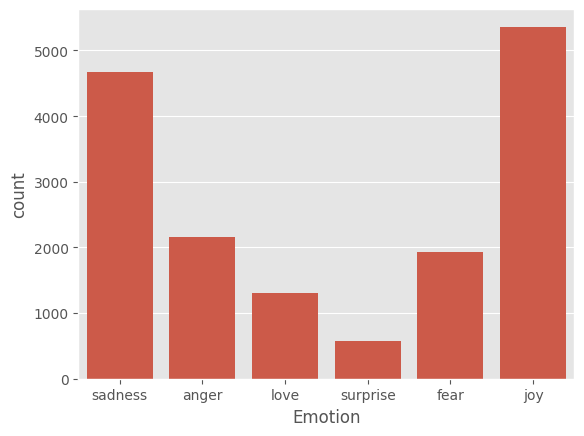

In [18]:
sns.countplot(x='Emotion', data=train_data)
plt.show()

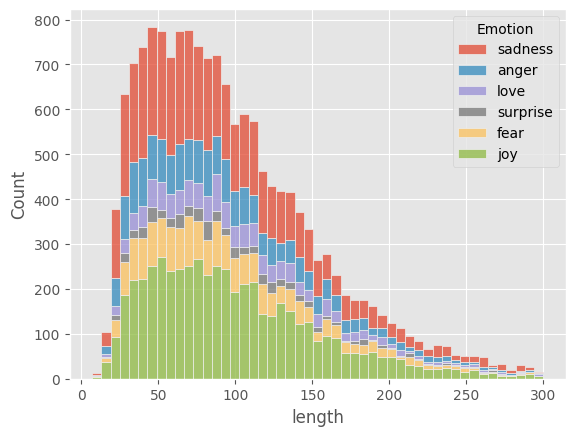

In [19]:
df2 = train_data.copy()
df2['length'] = [len(x) for x in train_data['Comment']]
length_value = df2['length'].values
sns.histplot(data=df2, x='length',hue='Emotion',multiple = 'stack')
plt.show()

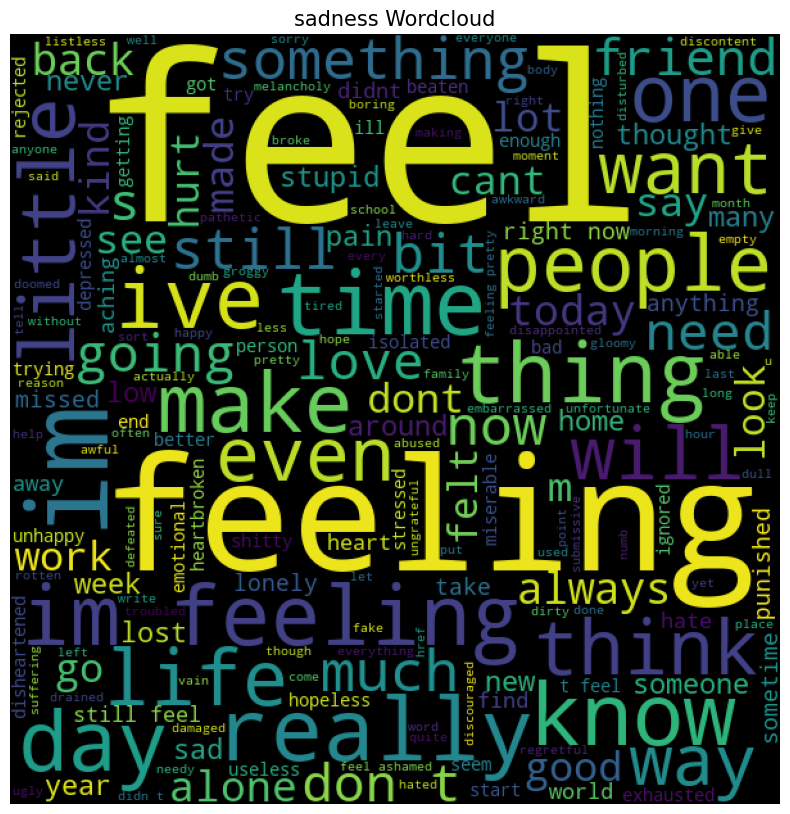

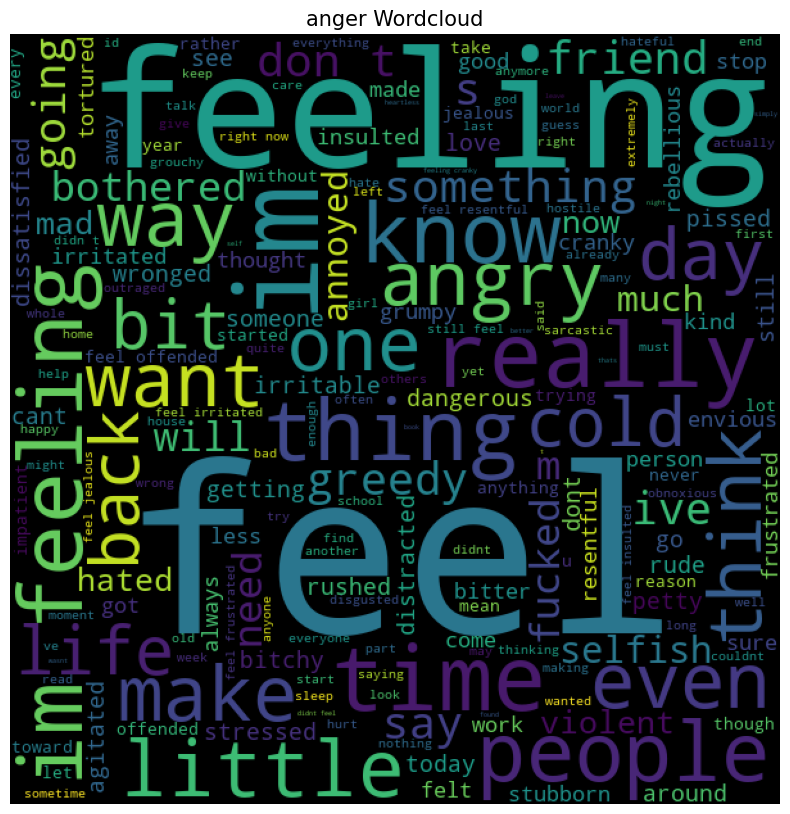

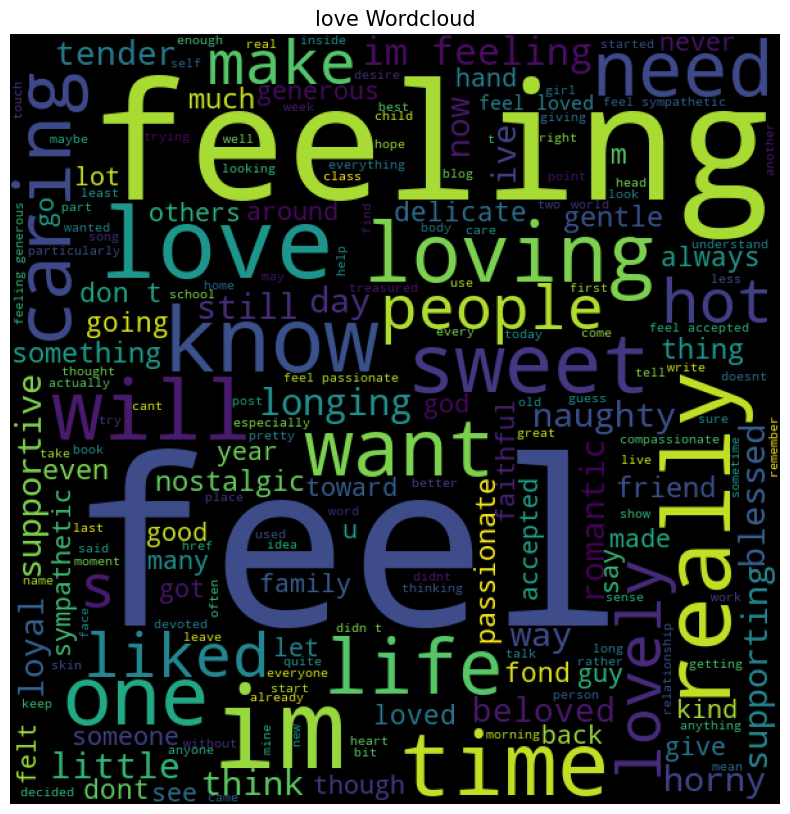

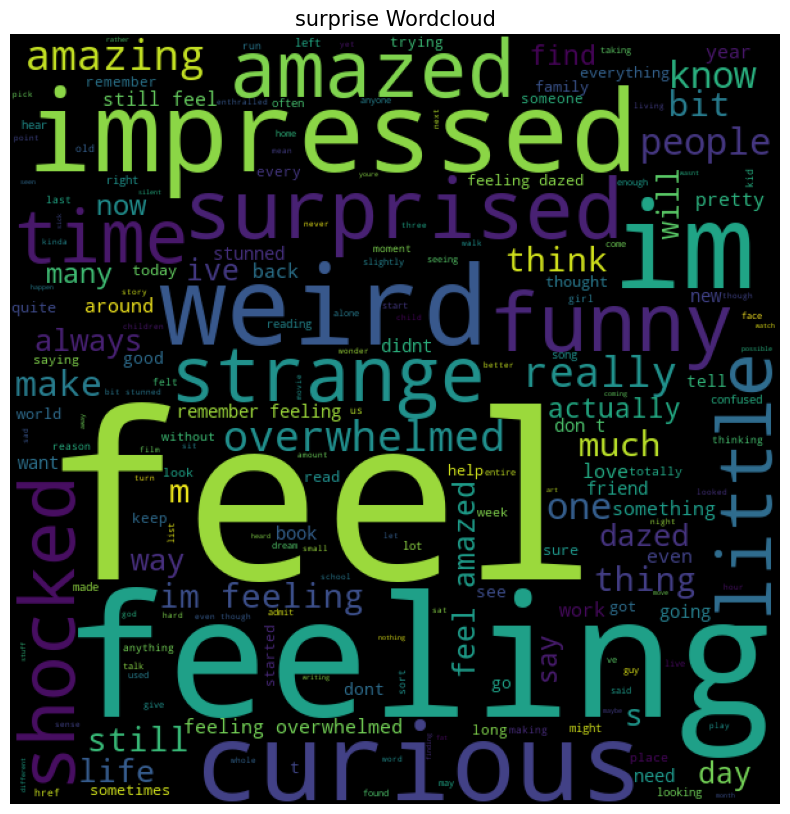

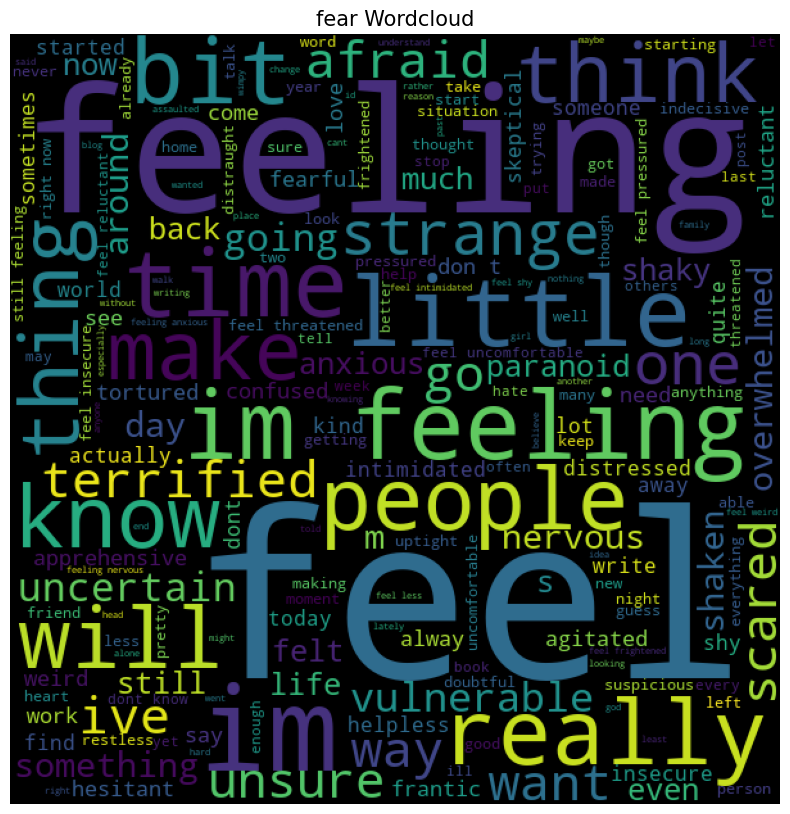

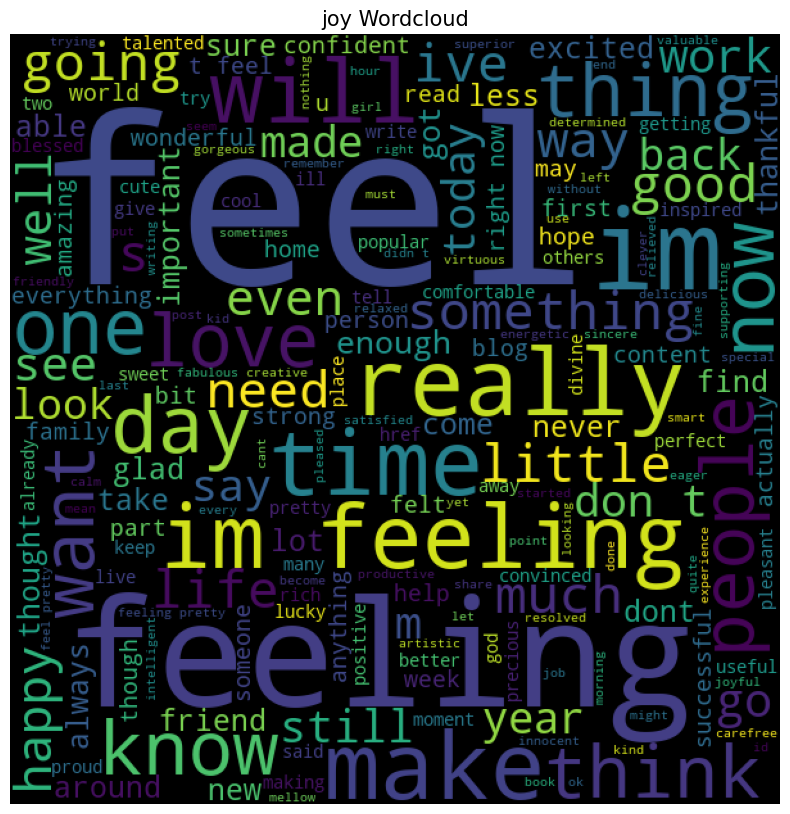

In [20]:
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10,10))
    plt.title(df + ' Wordcloud', size = 15)
    plt.imshow(wordcloud)
    plt.axis("off")
emotions_list = train_data['Emotion'].unique()
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion,'Comment']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

In [21]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])

In [22]:
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [24]:
df = train_data.copy()

In [25]:
df.head()

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20


In [26]:
from tqdm import tqdm
tqdm.pandas()
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

def clean_data(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]", " ",text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    return " ".join(text)

df['cleaned_comment']  = df['Comment'].progress_apply(clean_data)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhruv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 16000/16000 [00:02<00:00, 5580.60it/s]


In [27]:
df.head()

,Comment,Emotion,length,cleaned_comment
0,i didnt feel humiliated,4,23,didnt feel humili
1,i can go from feeling so hopeless to so damned...,4,108,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,0,48,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,3,92,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,0,20,feel grouchi


In [28]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_comment'], df['Emotion'], test_size=0.2, random_state=42)

In [29]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [30]:
X_train_tfidf.shape

(12800, 9257)

In [31]:
classifier={
    'MultinomialNB':MultinomialNB(),
    'LogisticRegression':LogisticRegression(),
    'Random Forest':RandomForestClassifier(),
    'Support Vector Machine': SVC(),
}
for name,clf in classifier.items():
    print(f"\n============{name}============")
    clf.fit(X_train_tfidf, y_train)
    y_pred_tfidf = clf.predict(X_test_tfidf)
    accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
    print(f"======={accuracy_tfidf}============")
    print("Classification Report")
    print(classification_report(y_test, y_pred_tfidf))


============MultinomialNB============
=======0.655============
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.31      0.46       427
           1       0.91      0.24      0.38       397
           2       0.58      0.98      0.73      1021
           3       1.00      0.03      0.06       296
           4       0.70      0.91      0.79       946
           5       1.00      0.01      0.02       113

    accuracy                           0.66      3200
   macro avg       0.85      0.41      0.41      3200
weighted avg       0.76      0.66      0.58      3200


============LogisticRegression============
=======0.829375============
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       427
           1       0.84      0.73      0.78       397
           2       0.78      0.94      0.85      1021
           3       0.80      0.49      0.61       296
      

In [32]:
lg = LogisticRegression()
lg.fit(X_train_tfidf, y_train)
lg_y_pred = lg.predict(X_test_tfidf)

In [33]:
def predict_emotion(input_text):
    cleaned_text = clean_data(input_text)
    input_vectorizer = tfidf_vectorizer.transform([cleaned_text])
    
    predicted_label = lg.predict(input_vectorizer)[0]
    predicted_emotion = lb.inverse_transform([predicted_label])[0]
    label = np.max(lg.predict(input_vectorizer))
    
    return predicted_emotion, label



In [34]:
predict_emotion("She break up with me")

('sadness', np.int64(4))

In [35]:
predict_emotion("I am very happy today!")

('joy', np.int64(2))

In [36]:
import pickle
pickle.dump(tfidf_vectorizer, open("tfidf_vectorizer.pkl","wb"))
pickle.dump(lg, open("logistic_regression.pkl","wb"))
pickle.dump(lb, open("label_encoder.pkl","wb"))

In [37]:
def text_cleaning(df, column, vocab_size, max_len, stopwords=[]):
    stemmer = PorterStemmer()
    corpus = []

    for text in df[column]:
        # Remove non-alphabetic characters
        text = re.sub("[^a-zA-Z]", " ", str(text))
        text = text.lower()
        words = text.split()
        # Stemming and removing stopwords
        words = [stemmer.stem(word) for word in words if word not in stopwords]
        cleaned_text = " ".join(words)
        corpus.append(cleaned_text)

    # One-hot encoding
    one_hot_word = [one_hot(word, vocab_size) for word in corpus]

    # Pad sequences
    padded_seq = pad_sequences(one_hot_word, maxlen=max_len, padding="pre")
    return padded_seq

In [42]:
# Drop rows with missing or non-string comments
train_data = train_data[train_data["Comment"].apply(lambda x: isinstance(x, str))].copy()

# Optional: fill missing values and strip whitespace
train_data["Comment"] = train_data["Comment"].fillna("").astype(str).str.strip()

In [44]:
!pip install numpy==1.24.4

     ---------------------------------------- 0.0/10.9 MB ? eta -:--:--
      --------------------------------------- 0.3/10.9 MB ? eta -:--:--
     -- ------------------------------------- 0.8/10.9 MB 2.1 MB/s eta 0:00:05
     ---- ----------------------------------- 1.3/10.9 MB 2.2 MB/s eta 0:00:05
     ------ --------------------------------- 1.8/10.9 MB 2.3 MB/s eta 0:00:04
     -------- ------------------------------- 2.4/10.9 MB 2.5 MB/s eta 0:00:04
     ------------ --------------------------- 3.4/10.9 MB 2.8 MB/s eta 0:00:03
     ---------------- ----------------------- 4.5/10.9 MB 3.1 MB/s eta 0:00:03
     -------------------- ------------------- 5.5/10.9 MB 3.4 MB/s eta 0:00:02
     ----------------------- ---------------- 6.3/10.9 MB 3.4 MB/s eta 0:00:02
     -------------------------- ------------- 7.3/10.9 MB 3.6 MB/s eta 0:00:02
     ------------------------------ --------- 8.4/10.9 MB 3.7 MB/s eta 0:00:01
     --------------------------------- ------ 9.2/10.9 MB 3.7 MB/s

  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [32 lines of output]
      Traceback (most recent call last):
        File "C:\Users\dhruv\AppData\Local\Programs\Python\Python313\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 389, in <module>
          main()
          ~~~~^^
        File "C:\Users\dhruv\AppData\Local\Programs\Python\Python313\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 373, in main
          json_out["return_val"] = hook(**hook_input["kwargs"])
                                   ~~~~^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\dhruv\AppData\Local\Programs\Python\Python313\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 137, in get_requires_for_build_wheel
          backend = _build_backend()
        File "C:\Users\dhruv\AppData\Local\Programs\Python\Python313\Lib\site-packages\pip\_ven

In [45]:
X_train = text_cleaning(train_data, "Comment", vocab_size=11000, max_len=300)
Y_train = to_categorical(train_data['Emotion'])
 

AttributeError: `np.unicode_` was removed in the NumPy 2.0 release. Use `np.str_` instead.

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
model = Sequential()
model.add(Embedding(input_dim = 11000, output_dim = 150, input_length = 300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6, activation = 'softmax'))
model.compile(optimizer='adam', loss = "categorical_crossentropy", metrics=['accuracy'])

callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
model.fit(X_train, Y_train, epochs = 1, batch_size = 64, verbose = 1, callbacks=[callback])


c:\Users\dhruv\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


NameError: name 'Y_train' is not defined

In [67]:
model.save("model.h5")

In [68]:
from keras.models import load_model
model = load_model("model.h5")

In [69]:
def predictive_system_dl(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ",sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=300, padding="pre")
    return pad

In [70]:
sentence = predictive_system_dl("He hates me")
result = lb.inverse_transform([np.argmax(model.predict(sentence),axis=1)])[0]
prob = np.max(model.predict(sentence))
print(f"{result} with a probability of {prob}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
sadness with a probability of 0.5783585906028748


c:\Users\dhruv\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [72]:
with open("lb1.pkl", "wb") as f:
    pickle.dump(lb, f)
vocab_info  = {"vocab_size": 11000, "max_len": 300}    
with open("vocab_info.pkl", "wb") as f:
    pickle.dump(vocab_info, f)